In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

/ext3/miniconda3/envs/owl_boto/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-03 18:39:47.922037: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 18:39:51.258130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 18:39:51.258207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 18:39:51.

## Load Model

In [2]:
# https://huggingface.co/transformers/v3.2.0/custom_datasets.html

In [3]:
checkpoint = "google-bert/bert-base-multilingual-uncased" #xlm-roberta-base

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create Datasets

In [4]:
class HSDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
train_df = pd.read_csv("../data/sentiment/splits/english/train.csv")
val_df = pd.read_csv("../data/sentiment/splits/english/val.csv")
test_df = pd.read_csv("../data/sentiment/splits/turkish/test.csv")

train_encodings = tokenizer(train_df['Tweets'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_df['Tweets'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_df['Tweets'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_dataset = HSDataset(train_encodings, train_df['Label'].tolist())
val_dataset = HSDataset(val_encodings, val_df['Label'].tolist())
test_dataset = HSDataset(test_encodings, test_df['Label'].tolist())

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

In [7]:
class_instance_counts = torch.tensor(list(dict(Counter(train_df['Label'].tolist())).values()))
class_instance_probs = class_instance_counts/class_instance_counts.sum().item()
class_weights = 1 / class_instance_probs
class_weights.to(device)

tensor([1.9826, 2.0177], device='cuda:0')

In [8]:
class_instance_counts.sum().item()

8888

## Define Trainer

In [21]:
# https://huggingface.co/docs/transformers/main_classes/trainer

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits.squeeze()
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_steps=50,
    evaluation_strategy="steps",
    label_names=["Label"]
)

In [24]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=50,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=False,
group_by_length=False,
half_precision_backend=a

In [25]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'f1': f1,
        'accuracy': acc
    }

In [26]:
training_args.evaluation_strategy

<IntervalStrategy.STEPS: 'steps'>

In [27]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    class_weights=class_weights.to(device),
    compute_metrics = compute_metrics
)

In [28]:
# trainer.compute_metrics = compute_metrics

In [29]:
trainer.train()

Step,Training Loss,Validation Loss
50,0.177400,No log
100,0.199200,No log
150,0.167400,No log


KeyboardInterrupt: 

In [17]:
trainer.save_model('./results/mbert_ft_english_sentiment/model')

## Evaluation

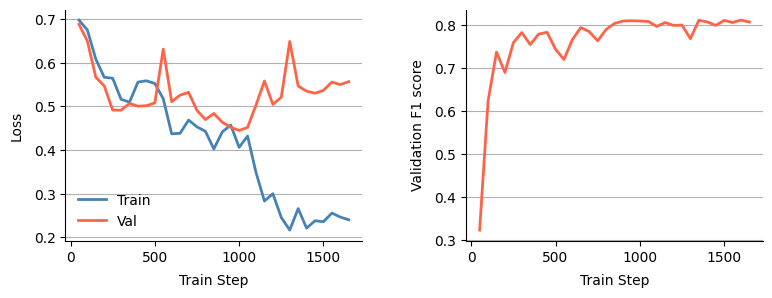

In [18]:
train_loss_df = pd.DataFrame(trainer.state.log_history[0:-1:2])
eval_loss_df = pd.DataFrame(trainer.state.log_history[1::2])

fig, axs = plt.subplots(1,2,figsize=(9,3), gridspec_kw={"wspace":0.35})
axs[0].plot(train_loss_df["step"], train_loss_df["loss"], color='steelblue', lw=2, label="Train")
axs[0].plot(eval_loss_df["step"], eval_loss_df["eval_loss"], color='tomato', lw=2, label="Val")
axs[0].set_xlabel("Train Step", labelpad=7)
axs[0].set_ylabel("Loss", labelpad=7)
axs[0].legend(frameon=False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].grid(axis='y')

axs[1].plot(eval_loss_df["step"], eval_loss_df["eval_f1"], color='tomato', lw=2)
axs[1].set_xlabel("Train Step", labelpad=7)
axs[1].set_ylabel("Validation F1 score", labelpad=7)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].grid(axis='x')

plt.grid()
plt.show()

### Test Results

In [19]:
test_preds = trainer.predict(test_dataset)
test_preds.metrics

{'test_loss': 1.1233277320861816,
 'test_f1': 0.6413124533929904,
 'test_accuracy': 0.5670567056705671,
 'test_runtime': 10.2955,
 'test_samples_per_second': 107.911,
 'test_steps_per_second': 6.799}